# Analysis - high-variance dimensions

In [2]:
import os
import numpy as np
import random
from sklearn.decomposition import PCA

from utils.UtilsIO import UtilsIO
from utils.UtilsPlotting import UtilsPlotting;
from utils.input_generation.InputGeneratorCtxt import InputGeneratorCtxt
from utils.input_generation.InputGeneratorSWG import InputGeneratorSWG
from utils.run_one_forwardPass import run_one_forwardPass
from utils.remove_dimension_from_weight_matrix import remove_dimension_from_weight_matrix
from utils.get_mse import get_mse
from utils.get_state_distance_between_trajs import get_state_distance_between_trajs

UIO  = UtilsIO()
UPlt = UtilsPlotting()

base_dir_data = '../data'

In [3]:
# network settings
net_id = 1
network_type = 'ctxt'  # 'swg': sine wave generator network 'ctxt': context-dependent integration network

# noise settings
with_netnoise    = 1  # 0 or 1
with_inputnoise  = 1  # 0 or 1, only for ctxt network

seed_run   = 1001
seed_input = 1000

# SHARED CONSTANTS / PARAMETERS
# load network weights
path_to_weights = os.path.join(base_dir_data, 'pretrained_networks', network_type, network_type+'_weights.h5')
[n_Wru_v, n_Wrr_n, m_Wzr_n, n_x0_c, n_bx_1, m_bz_1] = UIO.load_weights(path_to_weights, net_id)
n_units = np.shape(n_Wrr_n)[0]

# network noise
if with_netnoise:
    net_noise   = 'default'
else:
    net_noise   = 0

# generate network inputs to run network
random.seed(seed_input)
if network_type == 'swg':
    n_trials = 51*3  # total, over all 51 frequencies
    [all_freqs, all_freq_ids, inputs, targets, conditionIds] = InputGeneratorSWG().get_sine_wave_generator_inputOutputDataset(n_trials)
    
elif network_type == 'ctxt':
    n_trials = 5  # trials per context and per input coherency
    [coherencies_trial, conditionIds, inputs, targets] = InputGeneratorCtxt().get_ctxt_dep_integrator_inputOutputDataset(n_trials, with_inputnoise)
    
else:
    raise Exception("Network type unknown, please set network_type to 'swg' or 'ctxt'")

## Dimensionality of high-variance dimensions of W

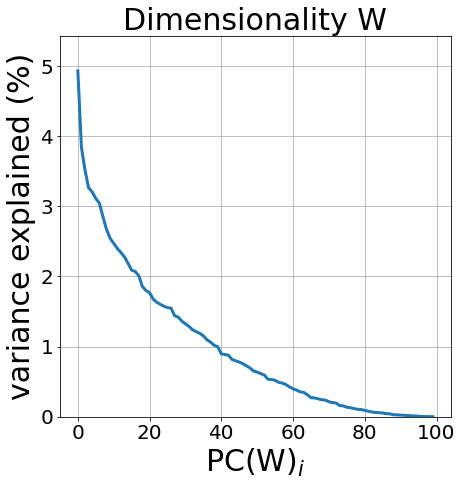

In [4]:
# plot dimensionality of high-variance dimensions (perform SVD(W))
_, S, _ = np.linalg.svd(n_Wrr_n)
S = np.square(S)
[fig, ax] = UPlt.plot_lineplot(np.arange(n_units), S/np.sum(S)*100, "Dimensionality W", "PC(W)$_i$", "variance explained (%)")

## Dimensionality of network activity

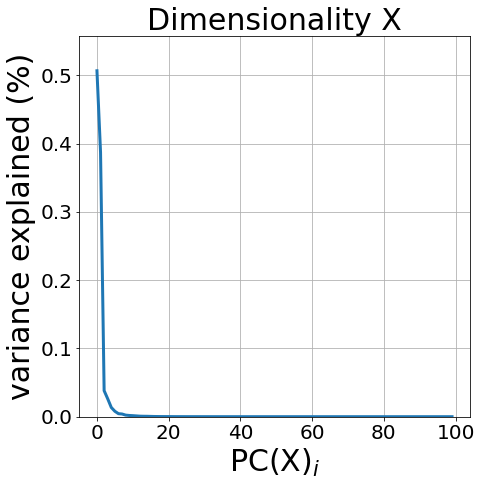

In [5]:
# run full-rank network
forwardPass_fullRank = run_one_forwardPass(n_Wru_v, n_Wrr_n, m_Wzr_n, n_x0_c, n_bx_1, m_bz_1, inputs, conditionIds, seed_run, net_noise)

# plot dimensionality of network activities
net_activities = np.reshape(forwardPass_fullRank["n_x_t"], [n_units, -1])
pca = PCA(n_components=n_units)
pca.fit(net_activities.T)  # [n_samples, n_features]
[fig, ax] = UPlt.plot_lineplot(np.arange(n_units), pca.explained_variance_ratio_, "Dimensionality X", "PC(X)$_i$", "variance explained (%)")

## Performance over sequentially removing high-variance dimensions from W

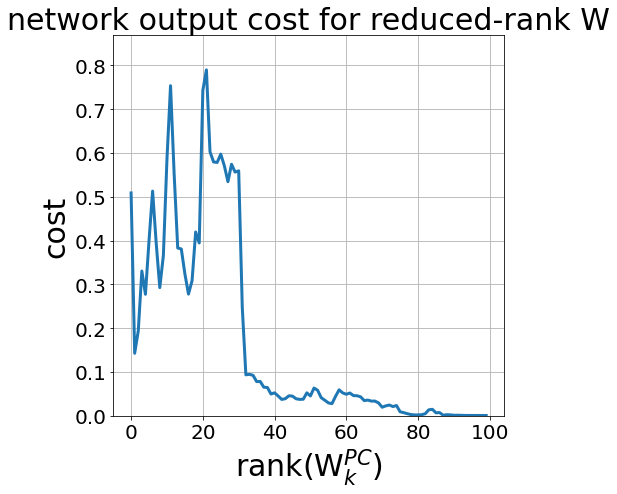

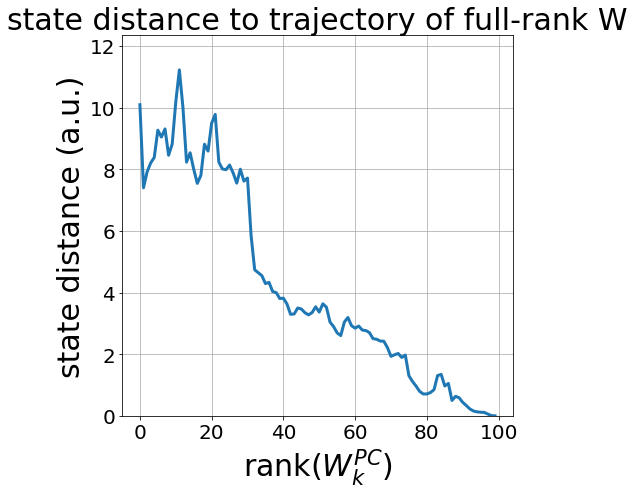

In [6]:
# get high-variance dimensions
[U, _, _] = np.linalg.svd(n_Wrr_n)

# run network with reduced-rank W and collect performance measures
# ( = mean squared error (mse) & State distance between full-rank and reduced-rank network trajectories)
n_high_var_dims   = n_units
mses              = np.full([n_high_var_dims, 1], np.nan)
statedists_to_org = np.full([n_high_var_dims, 1], np.nan)
for dim_nr in range(n_high_var_dims):
    
    # modify W
    n_Wrr_n_modified = remove_dimension_from_weight_matrix(n_Wrr_n, U[:,dim_nr+1:n_units], 'columns')

    # run modified network
    forwardPass = run_one_forwardPass(n_Wru_v, n_Wrr_n_modified, m_Wzr_n, n_x0_c, n_bx_1, m_bz_1, inputs, conditionIds, seed_run, net_noise)

    # get performance measures
    mses[dim_nr, 0] = get_mse(forwardPass["m_z_t"], targets, 'all')
    statedists_to_org[dim_nr, 0] = get_state_distance_between_trajs(forwardPass["n_x_t"], forwardPass_fullRank["n_x_t"])

# plot
[fig, ax] = UPlt.plot_lineplot(np.arange(n_units), mses, "network output cost for reduced-rank W", "rank(W$^{PC}_k$)", "cost")
[fig, ax] = UPlt.plot_lineplot(np.arange(n_units), statedists_to_org, "state distance to trajectory of full-rank W", "rank($W^{PC}_k$)", "state distance (a.u.)")